In [ ]:
!pip install keras-tuner

     |████████████████████████████████| 71kB 3.9MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.2-cp37-none-any.whl size=78938 sha256=5db1a6a02212bcb440d01d00c23022d874961a9e19c61151abc87fabaf2ed60f
  Stored in directory: /root/.cache/pip/wheels/bb/a1/8a/7c3de0efb3707a1701b36ebbfdbc4e67aedf6d4943a1f463d6
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp37-none-any.whl size=15356 sha256=bd8a6f4793de2bb53a619b616b24b21cb1fa733c0bdf7a2962990783ce72a93c
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables


In [ ]:
import cv2
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import time

from keras.models import Sequential 
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.model_selection import train_test_split


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/MSc Computational Neuroscience, Cognition & AI/MLis2/ML Project/code/YOLOv3_TF2/

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1lVSXhv7tm507dxrIt3znhnHFrg6oJRq8/ML Project/code/YOLOv3_TF2


In [ ]:
code_dir='/content/drive/MyDrive/MSc Computational Neuroscience, Cognition & AI/MLis2/ML Project/code/'
masks_dir=code_dir+'/data/training_data/training_masks/'
masks_list=os.listdir(masks_dir)
print(len(masks_list), masks_list[:5])

# target values
dataframe = pd.read_csv(code_dir+"/YOLOv3_TF2/data/training_norm.csv")
dataset = np.array(dataframe.values)
print(dataset[:5])
MASK_HEIGHT, MASK_WIDTH= 128, 128
INPUT_HEIGHT, INPUT_WIDTH= 88, 128

13793 ['12799.npy', '12800.npy', '12801.npy', '12802.npy', '12803.npy']
[[1.     0.4375 0.    ]
 [2.     0.8125 1.    ]
 [3.     0.4375 1.    ]
 [4.     0.625  1.    ]
 [5.     0.5    0.    ]]


# Make dataset

In [ ]:
boxes_df = pd.read_csv(code_dir+"YOLOv3_TF2/data/prediction_boxes.csv", header=None)
boxes= np.array(boxes_df.values) #box, car, green light, left signal, person, red light, right signal, tree
print(boxes.shape)
print(boxes[0])

(13797, 32)
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.49118881 0.49458158
 0.3445231  0.83723104 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


In [ ]:
#nb of red and green lights ['box','car', 'green light', 'left signal', 'person', 'red light', 'right signal', 'tree']
GREEN=boxes[:, 8:12]
RED=boxes[:, 20:24]
r,g=0,0
for red, green in zip(RED, GREEN):
  if np.sum(red)!=0:
    r+=1
  if np.sum(green)!=0:
    g+=1
print('nb of red signals=', r, 'nb of green signals=', g)

nb of red signals= 137 nb of green signals= 102


In [ ]:
# left signal, right signal
left_boxes=boxes[:,12:16]
right_boxes=boxes[:,24:28]
print(left_boxes.shape, right_boxes.shape)

(13797, 4) (13797, 4)


nb of data 13793


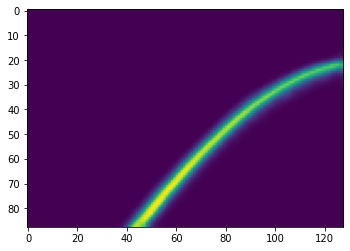

In [ ]:
# CHECK
N=len(masks_list)
print('nb of data', N)
n=np.random.randint(N)
mask_path=os.path.join(masks_dir, str(n)+'.npy')
mask= np.load(mask_path)
mask=mask[MASK_HEIGHT-INPUT_HEIGHT:, :INPUT_WIDTH]
plt.imshow(mask)

### First creation of X

In [ ]:
ANGLE=dataset[:, 1]

#X = np.zeros((N,INPUT_HEIGHT, INPUT_WIDTH, 1), dtype=np.float32)
X, Y=[], []

i=0
for mask in masks_list:
  i+=1
  if i%300==0:
    print(round(i/len( masks_list)*100 ), '%')
  id=int(mask[:-4])-1
  mask_path=os.path.join(masks_dir, mask)
  if id<13797:
    if sum(left_boxes[id,:])==0 and sum(right_boxes[id,:])==0: #remove turn left and right images
      mask= np.load(mask_path)
      mask=mask[MASK_HEIGHT-INPUT_HEIGHT:, :]
      X.append(mask)
      Y.append(ANGLE[id])



In [ ]:
print( np.shape(X), np.shape(Y))

In [ ]:
X= np.reshape(X, (13253, INPUT_HEIGHT, INPUT_WIDTH, 1))
Y=np.array(Y)
print(np.shape(X), np.shape(Y))

In [ ]:
X_path=code_dir+'data/training_data/X_masks.npy'
np.save(X_path, X)
Y_path=code_dir+'data/training_data/Y_masks.npy'
np.save(Y_path, Y)

### Upload X

In [ ]:
X_path=code_dir+'data/training_data/X_masks.npy'
X=np.load(X_path)
Y_path=code_dir+'data/training_data/Y_masks.npy'
Y=np.load(Y_path)

print(np.shape(X), np.shape(Y))

(13253, 88, 128, 1) (13253,)


predicted angle= 0.75


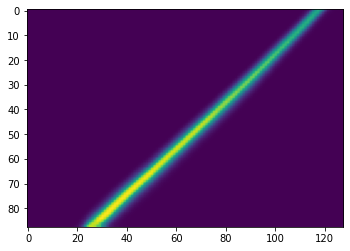

In [ ]:
n=np.random.randint(len(X))
mask, angle=X[n], Y[n]
print('predicted angle=', angle)
mask=np.reshape(mask, (INPUT_HEIGHT, INPUT_WIDTH))
plt.imshow(mask)

# Create model

In [ ]:
def nvidia_model():
  model = Sequential()
  model.add(Flatten(input_shape=(INPUT_HEIGHT, INPUT_WIDTH ,1)))
  model.add(Dropout(0.2)) #randomly turn 50% of inputs into 0 45
  model.add(Dense(100,activation='elu'))
  model.add(Dropout(0.2))
  model.add(Dense(50,activation='elu'))
  model.add(Dense(10,activation='elu'))
  model.add(Dense(1)) #outputs the proposed steering angle

  model.compile(loss='mse', optimizer=Adam(lr=0.001))

  return model

In [ ]:
def nvidia_model():
  model = Sequential()
  model.add(Flatten( input_shape=(INPUT_HEIGHT, INPUT_WIDTH ,1)))
  #model.add(Dense(5000,activation='elu'))
  model.add(Dense(1000,activation='elu'))
  model.add(Dropout(0.2))
  model.add(Dense(100,activation='elu'))
  model.add(Dense(50,activation='elu'))
  model.add(Dense(10,activation='elu'))
  model.add(Dense(1))# , activation='sigmoid')) #outputs the proposed steering angle
  model.compile(loss="mean_absolute_error", optimizer=Adam(lr=0.00005)) # loss="mean_absolute_error"/ loss="mean_squared_error"

  return model

In [ ]:
model = nvidia_model()
print(model.summary())

In [ ]:
def nvidia_model():
    model = Sequential(name='Nvidia_Model')
    
    # elu=Expenential Linear Unit, similar to leaky Relu
    # skipping 1st hiddel layer (nomralization layer), as we have normalized the data
    
    # Convolution Layers
    model.add(Conv2D(24, (5, 5), strides=(2, 2), input_shape=(88, 128, 1), activation='elu')) 
    model.add(Conv2D(36, (5, 5), strides=(2, 2), activation='elu')) 
    model.add(Conv2D(48, (5, 5), strides=(2, 2), activation='elu')) 
    model.add(Conv2D(64, (3, 3), activation='elu')) 
    model.add(Dropout(0.2)) # not in original model. added for more robustness
    model.add(Conv2D(64, (3, 3), activation='elu')) 
    
    # Fully Connected Layers
    model.add(Flatten())
    model.add(Dropout(0.2)) # not in original model. added for more robustness
    model.add(Dense(100, activation='elu'))
    model.add(Dense(50, activation='elu'))
    model.add(Dense(10, activation='elu'))
    
    # output layer: turn angle (from 45-135, 90 is straight, <90 turn left, >90 turn right)
    model.add(Dense(1, activation='linear')) 
    
    # since this is a regression problem not classification problem,
    # we use MSE (Mean Squared Error) as loss function
    optimizer = Adam(lr=1e-3) # lr is learning rate
    model.compile(loss='mse', optimizer=optimizer)
    
    return model

model = nvidia_model()
model.summary()

Model: "Nvidia_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 42, 62, 24)        624       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 19, 29, 36)        21636     
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 8, 13, 48)         43248     
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 6, 11, 64)         27712     
_________________________________________________________________
dropout_4 (Dropout)          (None, 6, 11, 64)         0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 4, 9, 64)          36928     
_________________________________________________________________
flatten_2 (Flatten)          (None, 2304)             

In [ ]:
# Only run once
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, shuffle=True)
print(len(X_train), len(X_test), np.shape(X_train[0]))

11927 1326 (88, 128, 1)


### Keras Tuner

In [ ]:
# Only run once
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, shuffle=True)
print(len(X_train), len(X_test), np.shape(X_train[0]))

11927 1326 (88, 128, 1)


In [ ]:
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

In [ ]:
def nvidia_model(hp):
  model = keras.Sequential()
  
  for i in range(hp.Int('num_C_layers',2,20)):
    model.add(Conv2D( filters=(hp.Int('C_units_' +str(i), min_value=12, max_value=100, step=32)), 
                               kernel_size=(hp.Choice('conv_kern_'+str(i), values=[3,5])), activation = 'elu'))
  model.add(Flatten( input_shape=(INPUT_HEIGHT, INPUT_WIDTH ,1)))
  for i in range(hp.Int('num_D_layers',2,20)):
    model.add(Dense(units=hp.Int('D_units_' +str(i), min_value=32, max_value=512, step=32), activation = 'elu'))
  model.add(Dropout(rate=hp.Float('dropout_2', min_value=0.0, max_value=0.5, step=0.05)))
  model.add(Dense(1)) #activation func? linear? 
  model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2,1e-3,1e-4])),
                                          loss='mean_squared_error', metrics=['mean_squared_error'])

  return model

In [ ]:
tuner_search = RandomSearch(nvidia_model, objective='val_loss',max_trials=5, executions_per_trial=5, directory='project_new7',project_name='kerasTuner_LaneDetection')

In [ ]:
tuner_search.search(X_train, Y_train, steps_per_epoch=300, epochs=10, validation_data=(X_test, Y_test))
model_best = tuner_search.get_best_models(num_models=1)[0]
model_best.summary()
tuner_search.get_best_hyperparameters()[0].values

earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('/content/nvidia.h5', verbose=1, save_best_only=True)
history=model_best.fit(X_train,Y_train, batch_size=32 ,epochs=30, validation_data=(X_test, Y_test), callbacks=[earlystopper, checkpointer])

loss=history.history['loss']; val_loss=history.history['val_loss']
plt.plot(loss,'b-', label='loss')
plt.plot(val_loss,'r-', label='val_loss')
plt.legend()
plt.xlabel('epochs')


# Load the best checkpoint model
model_path='/content/nvidia.h5'
model=keras.models.load_model(model_path)


model_path=code_dir+'YOLOv3_TF2/weights/nvidia_new.h5'
model.save(model_path)


Trial 1 Complete [00h 25m 42s]
val_loss: 0.005653108935803175

Best val_loss So Far: 0.005653108935803175
Total elapsed time: 00h 25m 42s

Search: Running Trial #2

Hyperparameter    |Value             |Best Value So Far 
num_C_layers      |2                 |11                
C_units_0         |172               |44                
conv_kern_0       |3                 |3                 
C_units_1         |492               |268               
conv_kern_1       |5                 |3                 
num_D_layers      |11                |17                
D_units_0         |160               |384               
D_units_1         |192               |128               
dropout_2         |0.05              |0.4               
learning_rate     |0.0001            |0.0001            
C_units_2         |268               |12                
conv_kern_2       |5                 |3                 
C_units_3         |428               |12                
conv_kern_3       |3                 

ResourceExhaustedError: ignored

In [ ]:
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('/content/nvidia.h5', verbose=1, save_best_only=True)
history=model_best.fit(X_train,Y_train, batch_size=32 ,epochs=30, validation_data=(X_test, Y_test), callbacks=[earlystopper, checkpointer]) #validation_steps=80

Epoch 1/30
373/373 [==============================] - 2s 4ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - val_loss: 0.0051 - val_mean_squared_error: 0.0051

Epoch 00001: val_loss improved from inf to 0.00510, saving model to /content/nvidia.h5
Epoch 2/30
373/373 [==============================] - 1s 4ms/step - loss: 0.0044 - mean_squared_error: 0.0044 - val_loss: 0.0051 - val_mean_squared_error: 0.0051

Epoch 00002: val_loss did not improve from 0.00510
Epoch 3/30
373/373 [==============================] - 1s 4ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - val_loss: 0.0060 - val_mean_squared_error: 0.0060

Epoch 00003: val_loss did not improve from 0.00510
Epoch 4/30
373/373 [==============================] - 1s 3ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - val_loss: 0.0053 - val_mean_squared_error: 0.0053

Epoch 00004: val_loss did not improve from 0.00510
Epoch 5/30
373/373 [==============================] - 1s 4ms/step - loss: 0.0035 - mean_squared_error: 0.003

### Train

In [ ]:
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('/content/nvidia.h5', verbose=1, save_best_only=True)
history=model.fit(X_train,Y_train, batch_size=32 ,epochs=30, validation_data=(X_test, Y_test), callbacks=[earlystopper, checkpointer]) #validation_steps=80

Epoch 1/30
373/373 [==============================] - 18s 6ms/step - loss: 0.0486 - val_loss: 0.0063

Epoch 00001: val_loss improved from inf to 0.00634, saving model to /content/nvidia.h5
Epoch 2/30
373/373 [==============================] - 2s 5ms/step - loss: 0.0077 - val_loss: 0.0065

Epoch 00002: val_loss did not improve from 0.00634
Epoch 3/30
373/373 [==============================] - 2s 5ms/step - loss: 0.0068 - val_loss: 0.0062

Epoch 00003: val_loss improved from 0.00634 to 0.00625, saving model to /content/nvidia.h5
Epoch 4/30
373/373 [==============================] - 2s 5ms/step - loss: 0.0064 - val_loss: 0.0057

Epoch 00004: val_loss improved from 0.00625 to 0.00573, saving model to /content/nvidia.h5
Epoch 5/30
373/373 [==============================] - 2s 5ms/step - loss: 0.0062 - val_loss: 0.0072

Epoch 00005: val_loss did not improve from 0.00573
Epoch 6/30
373/373 [==============================] - 2s 5ms/step - loss: 0.0061 - val_loss: 0.0053

Epoch 00006: val_loss 

Text(0.5, 0, 'epochs')

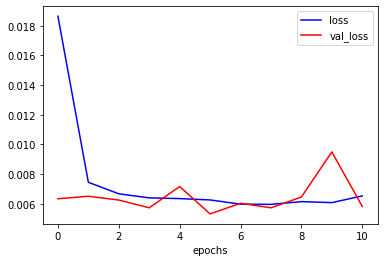

In [ ]:
loss=history.history['loss']; val_loss=history.history['val_loss']
plt.plot(loss,'b-', label='loss')
plt.plot(val_loss,'r-', label='val_loss')
plt.legend()
plt.xlabel('epochs')

# Evaluate

In [ ]:
# Load the best checkpoint model
model_path='/content/nvidia.h5'
model=keras.models.load_model(model_path)

mean time/prediction= 0.03516253500004041 s
predicted angle= 0.7996610403060913 ; target angle= 0.75


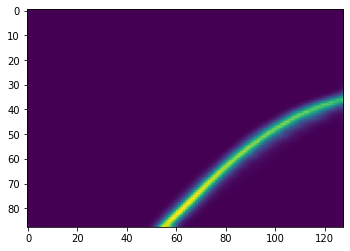

In [ ]:
n=np.random.randint(len(X_test))
mask, angle=X_test[n], Y_test[n]

t1=time.perf_counter()
predicted_angle=model.predict(np.reshape(mask,  (1, INPUT_HEIGHT, INPUT_WIDTH,1 ) ))
t2=time.perf_counter()
print('mean time/prediction=', (t2-t1), 's')
print('predicted angle=', float(predicted_angle), '; target angle=', angle)

mask=np.reshape(mask, (INPUT_HEIGHT, INPUT_WIDTH))
plt.imshow(mask)


In [ ]:
N=1000
mse=0
for n in range(0,N):
  mask, angle=X_test[n], Y_test[n]
  predicted_angle=model.predict(np.reshape(mask,  (1, INPUT_HEIGHT, INPUT_WIDTH,1 ) ))
  mse+=(float(predicted_angle)-angle)**2
print('mean mse=', mse/N)

mean mse= 0.005282951074828426


Save definitly

In [ ]:
model_path=code_dir+'YOLOv3_TF2/weights/nvidia_0051.h5'
model.save(model_path)

In [ ]:
# check the model can be uploaded from the drive
model_path=code_dir+'YOLOv3_TF2/weights/nvidia_0051.h5'
model=keras.models.load_model(model_path)

# Turning model

We make two special models to turn right and left

In [ ]:
boxes_df = pd.read_csv(code_dir+"YOLOv3_TF2/data/prediction_boxes.csv", header=None)
boxes= np.array(boxes_df.values) #box, car, green light, left signal, person, red light, right signal, tree
print(boxes.shape)
print(boxes[0])

(13797, 32)
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.49118881 0.49458158
 0.3445231  0.83723104 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


In [ ]:
# left signal, right signal
left_boxes=boxes[:,12:16]
right_boxes=boxes[:,24:28]
print(left_boxes.shape, right_boxes.shape)

(13797, 4) (13797, 4)


In [ ]:
ANGLE=dataset[:, 1]
X_right, Y_right=[], []
X_left, Y_left=[], []


for i in range(0, len(boxes)):
  if i%500==0:
    print(round(i/len(boxes)*100) , '%')
  if sum(left_boxes[i])>0:
    id=int(i+1)
    mask_name=str(id)+'.npy'
    mask_path=os.path.join(masks_dir, mask_name)
    if os.path.isfile(mask_path):
      mask= np.load(mask_path)
      mask=mask[MASK_HEIGHT-INPUT_HEIGHT:, :]
      X_left.append(mask)
      Y_left.append(ANGLE[i])

  if sum(right_boxes[i])>0:
    id=int(i+1)
    mask_name=str(id)+'.npy'
    mask_path=os.path.join(masks_dir, mask_name)
    if os.path.isfile(mask_path):
      mask= np.load(mask_path)
      mask=mask[MASK_HEIGHT-INPUT_HEIGHT:, :]
      X_right.append(mask)
      Y_right.append(ANGLE[i])


0 %
4 %
7 %
11 %
14 %
18 %
22 %
25 %
29 %
33 %
36 %
40 %
43 %
47 %
51 %
54 %
58 %
62 %
65 %
69 %
72 %
76 %
80 %
83 %
87 %
91 %
94 %
98 %


### Evaluate Paria nvidia

In [ ]:
def image_preprocessing(image):
  height = image.shape[0]
  image = image[int(height/3):,:,:] #remove half top of the image
  image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)  # YUV color for Nvidia model
  image = cv2.GaussianBlur(image, (3,3), 0) #reduce noise
  image = cv2.resize(image, (200,66)) # input image size (200,66) Nvidia model
  return image

In [ ]:
model=models.load(code_dir+'/weights/nvidia_original.h5')

In [ ]:
print('REGULAR MODEL PERFOMANCE')
model_path=code_dir+'YOLOv3_TF2/weights/nvidia_0049.h5'
model=keras.models.load_model(model_path)
model.compile(loss='mse', optimizer=Adam(lr=0.00001)) 

mse=[]
for mask,angle in zip(X_right, Y_right):
  predicted_angle=model.predict(np.reshape(mask,  (1, INPUT_HEIGHT, INPUT_WIDTH,1 ) ))
  mse.append((float(predicted_angle)-angle)**2)
print('RIGHT mse=', np.mean(mse))

mse=[]
for mask,angle in zip(X_left, Y_left):
  predicted_angle=model.predict(np.reshape(mask,  (1, INPUT_HEIGHT, INPUT_WIDTH,1 ) ))
  mse.append((float(predicted_angle)-angle)**2)
print('LEFT mse=', np.mean(mse))

REGULAR MODEL PERFOMANCE
RIGHT mse 0.06260941955343836
LEFT mse 0.038238404913365345


### Left

In [ ]:
# train left
X= np.reshape(X_left, (len(X_left), INPUT_HEIGHT, INPUT_WIDTH, 1))
Y=np.array(Y_left)

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1)
print(len(X_train), len(X_test), np.shape(X_train[0]))

184 21 (88, 128, 1)


Fine tune the already trained model

In [ ]:
model_path=code_dir+'YOLOv3_TF2/weights/nvidia_0049.h5'
model=keras.models.load_model(model_path)
model.compile(loss='mse', optimizer=Adam(lr=0.00001)) # change lr from 0.001 to 0.0001

In [ ]:
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('/content/left.h5', verbose=1, save_best_only=True)
history=model.fit(X_train,Y_train,batch_size=10 ,epochs=20, validation_data=(X_test, Y_test), callbacks=[earlystopper, checkpointer])

Epoch 1/20
19/19 [==============================] - 0s 7ms/step - loss: 0.0072 - val_loss: 0.0154

Epoch 00001: val_loss improved from inf to 0.01542, saving model to /content/left.h5
Epoch 2/20
19/19 [==============================] - 0s 5ms/step - loss: 0.0068 - val_loss: 0.0158

Epoch 00002: val_loss did not improve from 0.01542
Epoch 3/20
19/19 [==============================] - 0s 4ms/step - loss: 0.0069 - val_loss: 0.0163

Epoch 00003: val_loss did not improve from 0.01542
Epoch 4/20
19/19 [==============================] - 0s 4ms/step - loss: 0.0064 - val_loss: 0.0168

Epoch 00004: val_loss did not improve from 0.01542
Epoch 5/20
19/19 [==============================] - 0s 5ms/step - loss: 0.0064 - val_loss: 0.0169

Epoch 00005: val_loss did not improve from 0.01542
Epoch 6/20
19/19 [==============================] - 0s 5ms/step - loss: 0.0067 - val_loss: 0.0168

Epoch 00006: val_loss did not improve from 0.01542
Epoch 00006: early stopping


In [ ]:
model_path='/content/left.h5'
model=keras.models.load_model(model_path)

predicted angle= 0.3036847412586212 ; target angle= 0.4375


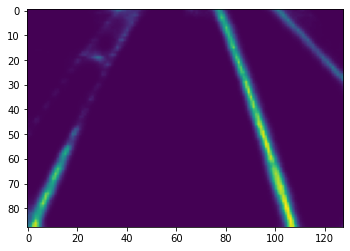

In [ ]:
n=np.random.randint(len(X_test))
mask, angle=X_test[n], Y_test[n]

predicted_angle=model.predict(np.reshape(mask,  (1, INPUT_HEIGHT, INPUT_WIDTH,1 ) ))
print('predicted angle=', float(predicted_angle), '; target angle=', angle)

mask=np.reshape(mask, (INPUT_HEIGHT, INPUT_WIDTH))
plt.imshow(mask)

In [ ]:
left_model_path=code_dir+'YOLOv3_TF2/weights/left.h5'
model.save(left_model_path)

### Right

In [ ]:
# train right
X= np.reshape(X_right, (len(X_right), INPUT_HEIGHT, INPUT_WIDTH, 1))
Y=np.array(Y_right)

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1)
print(len(X_train), len(X_test), np.shape(X_train[0]))

305 34 (88, 128, 1)


In [ ]:
model_path=code_dir+'YOLOv3_TF2/weights/nvidia.h5'
model=keras.models.load_model(model_path)
model.compile(loss='mse', optimizer=Adam(lr=0.000005)) # change lr from 0.001 to 0.0001

In [ ]:
earlystopper = EarlyStopping(patience=10, verbose=1)
checkpointer = ModelCheckpoint('/content/right.h5', verbose=1, save_best_only=True)
history=model.fit(X_train,Y_train,batch_size=5,epochs=20,validation_data=(X_test, Y_test), callbacks=[earlystopper, checkpointer])

Epoch 1/20
61/61 [==============================] - 0s 3ms/step - loss: 0.0104 - val_loss: 0.0261

Epoch 00001: val_loss improved from inf to 0.02609, saving model to /content/right.h5
Epoch 2/20
61/61 [==============================] - 0s 3ms/step - loss: 0.0103 - val_loss: 0.0260

Epoch 00002: val_loss improved from 0.02609 to 0.02600, saving model to /content/right.h5
Epoch 3/20
61/61 [==============================] - 0s 3ms/step - loss: 0.0094 - val_loss: 0.0264

Epoch 00003: val_loss did not improve from 0.02600
Epoch 4/20
61/61 [==============================] - 0s 3ms/step - loss: 0.0092 - val_loss: 0.0261

Epoch 00004: val_loss did not improve from 0.02600
Epoch 5/20
61/61 [==============================] - 0s 3ms/step - loss: 0.0089 - val_loss: 0.0267

Epoch 00005: val_loss did not improve from 0.02600
Epoch 6/20
61/61 [==============================] - 0s 3ms/step - loss: 0.0088 - val_loss: 0.0262

Epoch 00006: val_loss did not improve from 0.02600
Epoch 7/20
61/61 [========

In [ ]:
model_path='/content/right.h5'
model=keras.models.load_model(model_path)

predicted angle= 0.46109193563461304 ; target angle= 0.5


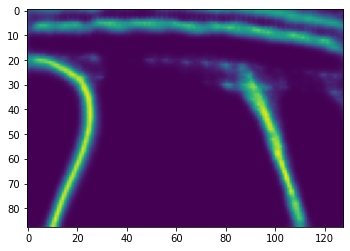

In [ ]:
n=np.random.randint(len(X_test))
mask, angle=X_test[n], Y_test[n]

predicted_angle=model.predict(np.reshape(mask,  (1, INPUT_HEIGHT, INPUT_WIDTH,1 ) ))
print('predicted angle=', float(predicted_angle), '; target angle=', angle)

mask=np.reshape(mask, (INPUT_HEIGHT, INPUT_WIDTH))
plt.imshow(mask)

In [ ]:
right_model_path=code_dir+'YOLOv3_TF2/weights/right.h5'
model.save(right_model_path)

# Speed 

In [ ]:
masks_dir=code_dir+'/data/training_data/masks_road_object/'
masks_list=os.listdir(masks_dir)
print(len(masks_list))
SPEED=dataset[:, 2]
print(SPEED[:5])

13144
[0. 1. 1. 1. 0.]


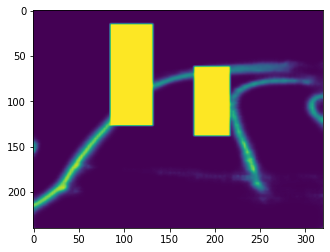

In [ ]:
n=np.random.randint(len(masks_list))
n=1587
mask_path=masks_dir+str(n)+'.npy'
mask=np.load(mask_path)
plt.figure()
mask=cv2.resize(mask, ( 320,240))
plt.imshow(mask)
plt.imsave('/content/speed_mask.png', mask)

### Create X, Y

In [ ]:
#X = np.zeros((N,MASK_HEIGHT, MASK_WIDTH= 128, 128, 1), dtype=np.float32)
X, Y=[], []
i=0
for mask in masks_list:
  i+=1
  if i%500==0:
    print(round(i/len( masks_list)*100 ), '%')
  id=int(mask[:-4])-1
  mask_path=os.path.join(masks_dir, mask)
  if id<13797:
      mask= np.load(mask_path)
      X.append(mask)
      Y.append(int(SPEED[id]))

4 %
8 %
11 %
15 %
19 %
23 %
27 %
30 %
34 %
38 %
42 %
46 %
49 %
53 %
57 %
61 %
65 %
68 %
72 %
76 %
80 %
84 %


KeyboardInterrupt: ignored

In [ ]:
print( np.shape(X), np.shape(Y))

In [ ]:
X= np.reshape(X, (13143, MASK_HEIGHT, MASK_WIDTH, 1))
Y=np.array(Y)
print(np.shape(X), np.shape(Y))

In [ ]:
X_path=code_dir+'data/training_data/X_masks_road_object.npy'
np.save(X_path, X)
Y_path=code_dir+'data/training_data/Y_masks_road_object.npy'
np.save(Y_path, Y)

### Load X, Y

In [ ]:
X_path=code_dir+'data/training_data/X_masks_road_object.npy'
X=np.load(X_path)
Y_path=code_dir+'data/training_data/Y_masks_road_object.npy'
Y=np.load(Y_path)
Y=np.array(Y)

print(np.shape(X), np.shape(Y))

(13143, 128, 128, 1) (13143,)


predicted speed= 1


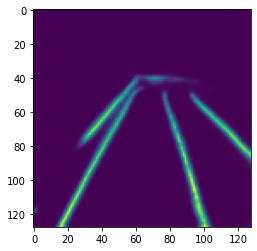

In [ ]:
n=np.random.randint(len(X))
mask, angle=X[n], Y[n]
print('predicted speed=', angle)
mask=np.reshape(mask, (MASK_HEIGHT, MASK_WIDTH))
plt.imshow(mask)


## Model

In [ ]:
def nvidia_model():
  model = Sequential()
  model.add(Flatten( input_shape=(MASK_HEIGHT, MASK_WIDTH ,1)))
  model.add(Dense(1000,activation='elu'))
  model.add(Dropout(0.2))
  model.add(Dense(100,activation='elu'))
  model.add(Dropout(0.2))
  model.add(Dense(50,activation='elu'))
  model.add(Dense(10,activation='elu'))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=Adam(lr=0.01))

  return model

In [ ]:
def nvidia_model():
  model = Sequential()
  model.add(Flatten( input_shape=(MASK_HEIGHT, MASK_WIDTH ,1)))
  model.add(Dense(1000,activation='elu'))
  # model.add(Dropout(0.2))
  # model.add(Dense(200,activation='elu'))
  model.add(Dense(50,activation='elu'))
  # model.add(Dropout(0.45))
  model.add(Dense(10,activation='elu'))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=Adam(lr=0.001))

  return model

In [ ]:
model = nvidia_model()
# print(model.summary())

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, shuffle=True)
print(len(X_train), len(X_test), np.shape(X_train[0]), np.shape(Y_train))

11828 1315 (128, 128, 1) (11828,)


In [ ]:
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('/content/speed.h5', verbose=1, save_best_only=True)
history=model.fit(X_train,Y_train,batch_size=64,epochs=30, validation_data=(X_test, Y_test), callbacks=[earlystopper, checkpointer]) #validation_steps=80

Epoch 1/30
185/185 [==============================] - 5s 9ms/step - loss: 0.7388 - accuracy: 0.8812 - val_loss: 0.1801 - val_accuracy: 0.9437

Epoch 00001: val_loss improved from inf to 0.18012, saving model to /content/speed.h5
Epoch 2/30
185/185 [==============================] - 1s 8ms/step - loss: 0.1779 - accuracy: 0.9493 - val_loss: 0.1618 - val_accuracy: 0.9498

Epoch 00002: val_loss improved from 0.18012 to 0.16175, saving model to /content/speed.h5
Epoch 3/30
185/185 [==============================] - 1s 8ms/step - loss: 0.1305 - accuracy: 0.9621 - val_loss: 0.1100 - val_accuracy: 0.9665

Epoch 00003: val_loss improved from 0.16175 to 0.11004, saving model to /content/speed.h5
Epoch 4/30
185/185 [==============================] - 1s 8ms/step - loss: 0.1248 - accuracy: 0.9663 - val_loss: 0.1007 - val_accuracy: 0.9643

Epoch 00004: val_loss improved from 0.11004 to 0.10071, saving model to /content/speed.h5
Epoch 5/30
185/185 [==============================] - 1s 8ms/step - loss

## Evaluate

In [ ]:
model_path='/content/speed.h5'
model=keras.models.load_model(model_path)

predicted speed= 0 ; target speed= 0 time= 0.04303480500038859


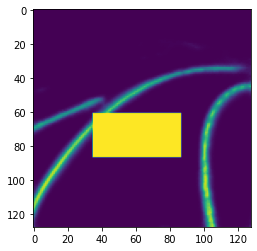

In [ ]:
import time
n=np.random.randint(len(X_test))
mask, speed=X_test[n], Y_test[n]
t1=time.perf_counter()

predicted_speed=model.predict(np.reshape(mask,  (1, MASK_HEIGHT, MASK_WIDTH,1 ) ))
t2=time.perf_counter()

print('predicted speed=', round(float(predicted_speed)), '; target speed=', speed, 'time=', t2-t1)

mask=np.reshape(mask, (MASK_HEIGHT, MASK_WIDTH))
plt.imshow(mask)

In [ ]:
speed_model_path=code_dir+'YOLOv3_TF2/weights/speed.h5'
model.save(speed_model_path)

# Draft


In [ ]:
def nvidia_model():
  model = Sequential()
  model.add(Conv2D(24, kernel_size= (5,5), strides=(2,2), input_shape=(INPUT_HEIGHT, INPUT_WIDTH ,1), activation='elu'))
  model.add(Conv2D(36, kernel_size= (5,5), strides=(2,2), activation='elu'))
  model.add(Conv2D(48, kernel_size= (5,5), strides=(2,2), activation='elu'))
  model.add(Conv2D(64, kernel_size= (3,3), activation='elu')) 
  model.add(Conv2D(64, kernel_size= (3,3), activation='elu'))
  model.add(Dropout(0.2)) #randomly turn 50% of inputs into 0 45

  model.add(Flatten())
  model.add(Dense(100,activation='elu'))
  model.add(Dropout(0.2))
  model.add(Dense(50,activation='elu'))
  model.add(Dense(10,activation='elu'))
  model.add(Dense(1)) #outputs the proposed steering angle

  model.compile(loss='mse', optimizer=Adam(lr=0.001))

  return model

In [ ]:
def nvidia_model():
  model = Sequential()
  model.add(Flatten( input_shape=(INPUT_HEIGHT, INPUT_WIDTH ,1)))
  model.add(Dense(1000,activation='elu'))
  model.add(Dropout(0.2))
  model.add(Dense(100,activation='elu'))
  model.add(Dropout(0.2))
  model.add(Dense(50,activation='elu'))
  model.add(Dense(10,activation='elu'))
  model.add(Dense(1))# , activation='sigmoid')) #outputs the proposed steering angle

  model.compile(loss='mse', optimizer=Adam(lr=0.001))

  return model